Evaluation of the embeddings model used for the ideological polarisation chapter.

In [43]:
# Imports
import gensim
import warnings
import scienceplots
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import multiprocessing
import logging
import pandas as pd
import random
from src.data.utils import string_to_list as st
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1
warnings.filterwarnings('ignore')
plt.style.use(['science', 'ieee', 'grid', 'vibrant', 'no-latex'])


#### Select interventions

In [18]:
data = pd.read_csv('../data/all-data-clean-tokenized.csv')

In [19]:
# Specific changes to merge IU & UP, and keep only majority parties.
# (Taken from the ideological polarisation notebook)

data['political_group'] = data['political_group'].str.replace('IU', 'UP')
groups = ['PSOE', 'PP', 'UP', 'VOX', 'CS']
data = data.loc[data['political_group'].isin(groups)]

data['pl'] = data['political_group'] + '-' + data['legislatura'].astype(str)
data['leg'] = 'L' + data['legislatura'].astype(str)
data = data.loc[data['text'] != 0].dropna().reset_index(drop=True)
data = data.loc[data['text'] != "['nan']"].reset_index(drop=True)

In [21]:
# Leaving only appropriate tags.
df = data[['pl', 'leg', 'phrases']]
df.columns = ['party', 'legislature', 'text']
df = df.loc[df['text'] != 0].dropna().reset_index(drop=True)
df = df.loc[df['text'] != "['nan']"].dropna().reset_index(drop=True)

#### Cross-Validation with 80% of the data each time.

- We re-train the model with a portion of the dataset. Place it in the matrix.  
- Repeat 10 times. Place all points in the embedding space. Observe the placement cloud.

In [261]:
# Running the model 10 times with 

def read_corpus(fname):
    for line in fname:
        # There was an error that made the words be a string instead of a list.
        l = line[2].strip('][').split(', ')
        fixed_list = []
        for item in l:
            fixed_list.append(item.replace("'", ""))

        yield gensim.models.doc2vec.TaggedDocument(fixed_list, [line[0], line[1]])
        #yield gensim.models.doc2vec.TaggedDocument(fixed_list, [line[0]])

def reduce_dimension(model, method='pca', n=2):
    speakers = [item for item in model.dv.index_to_key]  # if '-' in item]
    S = len(speakers)
    M = model.vector_size
    z = np.zeros((S, M))

    for i in range(S):
        z[i, :] = model.dv[i]

    if method == 'pca':
        dr = PCA(n_components=n, random_state=123)
    elif method == 'tsne':
        dr = TSNE(n_components=n)
    else:
        print('Error: methods allowed are "pca" and "tsne".')

    Z = dr.fit_transform(z)
    Z = pd.DataFrame(Z)

    columns = []
    for i in range(n):
        columns.append(f'dim{i}')
    Z.columns = columns

    Z['speaker'] = speakers

    return Z, dr

def cross_validate(df):

    placements = []

    for i in range(10):
        size = len(df)
        test_indexes = random.sample(range(size), int(size*0.2))

        test = df.loc[test_indexes]
        train = df.loc[~data.index.isin(test_indexes)]

        corpus = train.values.tolist()
        train_corpus = list(read_corpus(corpus))

        model = gensim.models.doc2vec.Doc2Vec(
            dm=1,
            vector_size=50,
            window=20,
            min_count=5,
            workers=cores,
            epochs=20,
            negative=5,
            sample=0.001)
        
        model.build_vocab(train_corpus)

        model.train(
            train_corpus,
            total_examples=len(train_corpus),
            epochs=model.epochs)
        
        Z, dr = reduce_dimension(model=model, method='pca')

        placements.append(Z)

    return placements

placements = cross_validate(df)

2023-05-19 13:26:50,897 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d50,n5,w20,mc5,s0.001,t8)', 'datetime': '2023-05-19T13:26:50.889802', 'gensim': '4.1.2', 'python': '3.8.13 (default, Mar 28 2022, 06:16:26) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-05-19 13:26:50,963 : INFO : collecting all words and their counts
2023-05-19 13:26:50,965 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2023-05-19 13:26:53,154 : INFO : PROGRESS: at example #10000, processed 4325607 words (1977677/s), 165126 word types, 8 tags
2023-05-19 13:26:56,691 : INFO : PROGRESS: at example #20000, processed 8232675 words (1106065/s), 221272 word types, 15 tags
2023-05-19 13:26:59,205 : INFO : PROGRESS: at example #30000, processed 11627853 words (1355861/s), 253602 word types, 25 tags
2023-05-19 13:27:01,801 : INFO : PROGRESS: at example #40000, processed 14815617 words (1253394/s), 280733 word types, 37 tags
2023-05-19 13

In [262]:
placements

[         dim0       dim1  speaker
 0   25.958699  -3.198557     UP-7
 1    3.962002   3.088278       L7
 2    0.915866  -4.594020   PSOE-7
 3  -26.543521  10.258943     PP-7
 4  -21.765766 -13.076668     PP-8
 5    4.253867   2.652336       L8
 6   -9.408943  18.507423   PSOE-8
 7   30.451709  -4.325858     UP-8
 8    2.360558  22.539398   PSOE-9
 9   -7.410567   7.759108       L9
 10  -8.661369 -16.804432     PP-9
 11 -30.754656   8.804605    PP-10
 12   6.019539  -6.967648      L10
 13  32.479304 -12.400209    UP-10
 14   2.212061  -1.517074  PSOE-10
 15 -16.880598   6.593340    PP-11
 16   1.611724  -3.220832      L11
 17  -3.462745  -5.694348    CS-11
 18  16.086547  -3.413861    UP-11
 19   2.608614   0.823327  PSOE-11
 20  -6.891880 -11.073751    CS-12
 21   3.647615  -2.727743      L12
 22  26.698723  -2.479447    UP-12
 23   3.870809   4.764656  PSOE-12
 24 -24.774376   6.408143    PP-12
 25  -2.956975  19.143237  PSOE-13
 26   1.617147   0.218057      L13
 27  -7.374158  -8.4

In [267]:
red = []
for i in range(10):
    red.append(get_color(placements[i]))

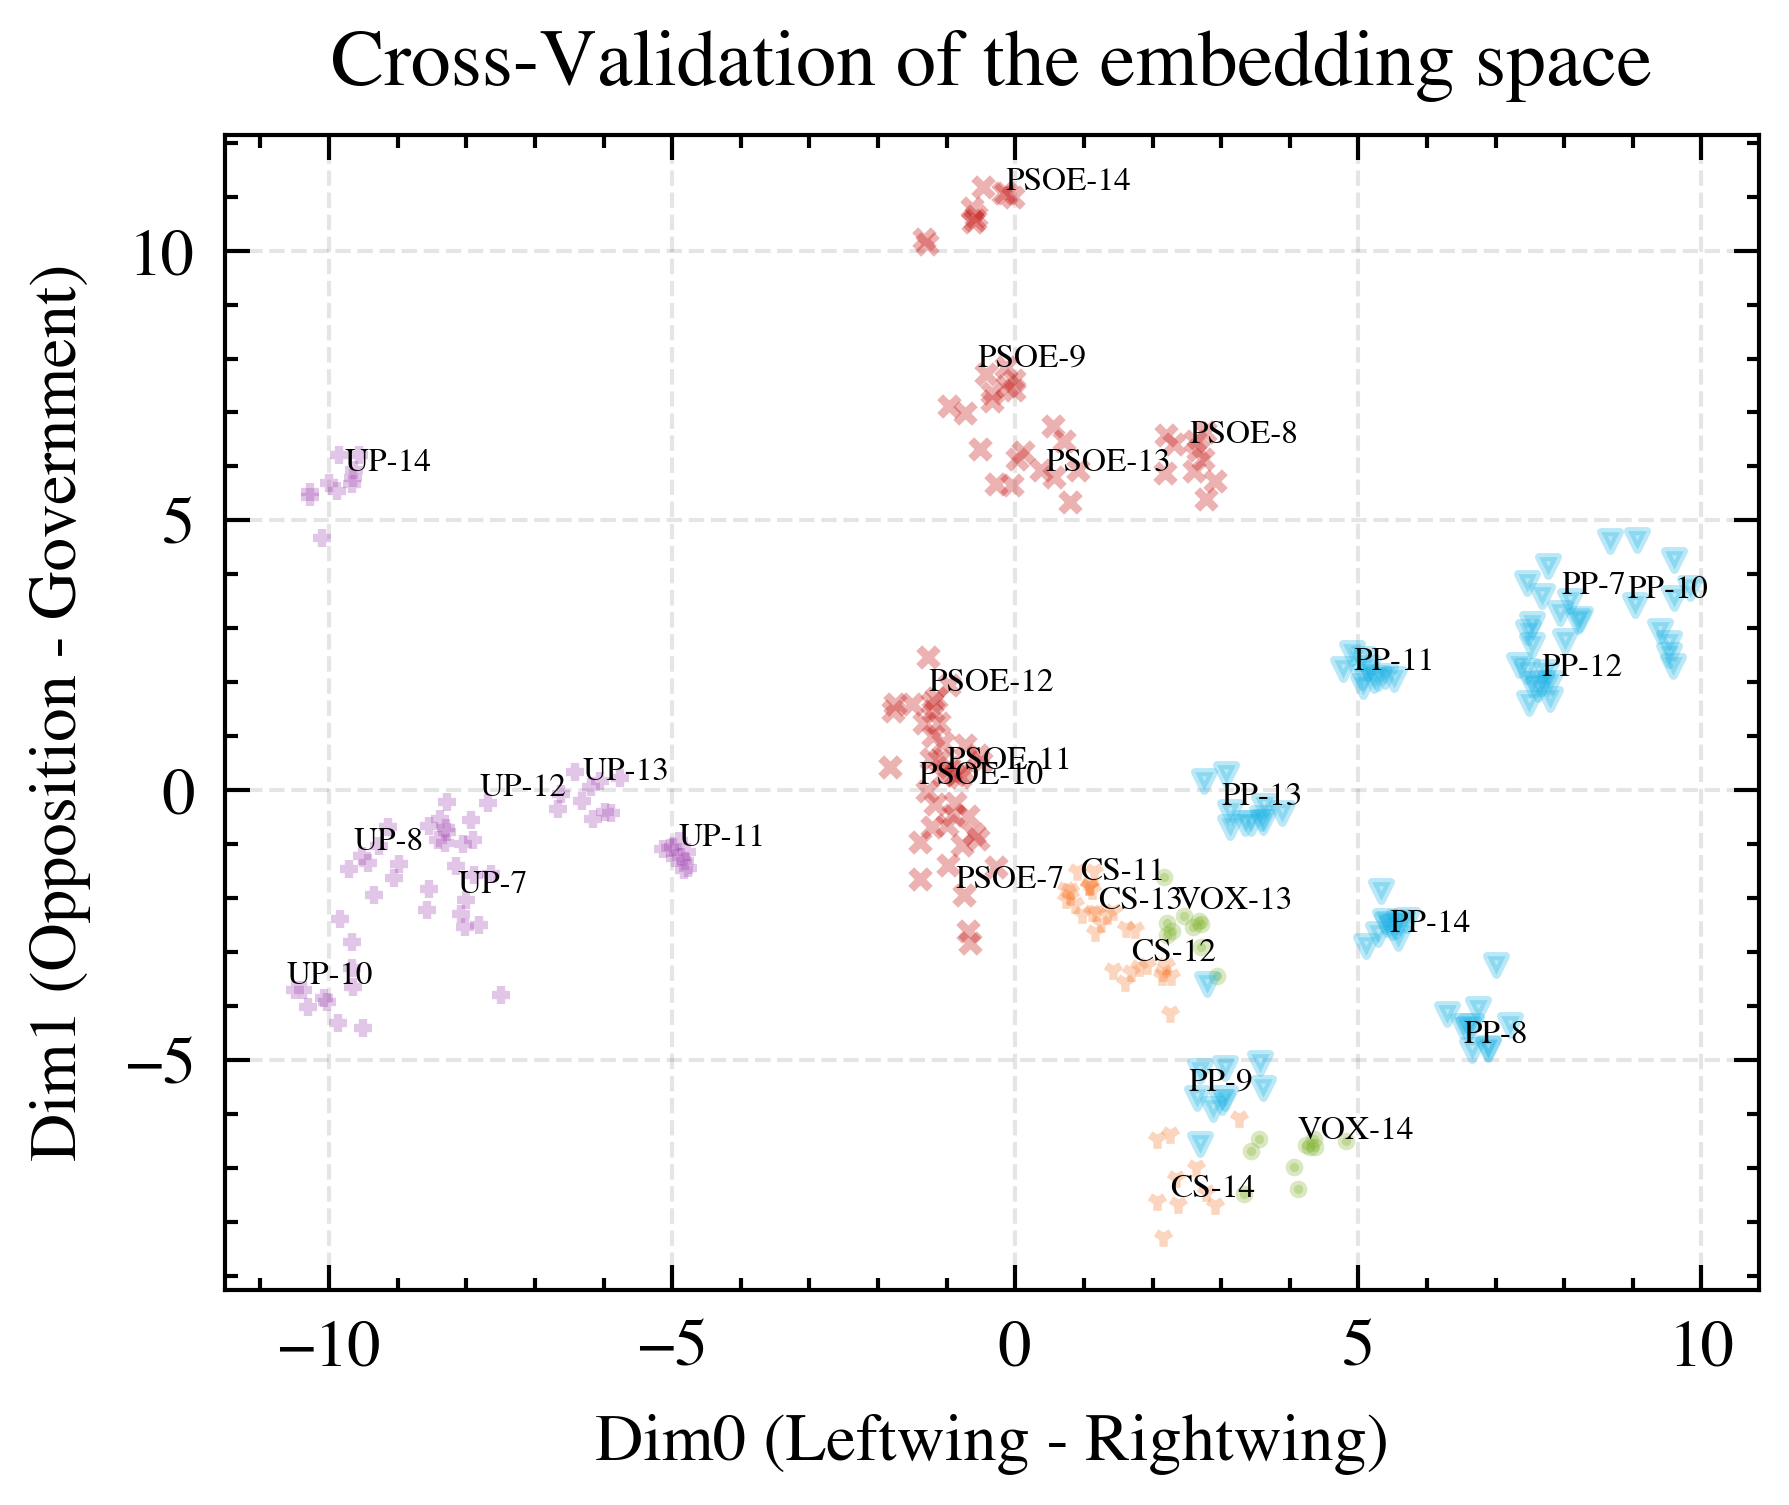

In [280]:
for i in range(10):
    rp = red[i].loc[red[i]['speaker'].str.contains('-')]

    for xp, yp, c, m in zip(rp.dim0*0.31*-1, rp.dim1*0.31, rp.col, rp.marker):
        plt.scatter(xp, yp, marker=m, c=c, s=5, alpha=.3)

# Change marker type depending on political party. Change marker size.

for label, x, y in zip(rp.speaker, rp.dim0*0.31*-1, rp.dim1*0.31):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-1, 0),
        textcoords='offset points', ha='left', va='bottom',
        fontsize=4)

plt.title('Cross-Validation of the embedding space')
plt.xlabel('Dim0 (Leftwing - Rightwing)')
plt.ylabel('Dim1 (Opposition - Government)')

plt.grid(alpha=.1)


#### "Accuracy" Calculation.

In [23]:
# Choose randomly 10% of the interventions for testing.
size = len(df)
test_indexes = random.sample(range(size), int(size*0.1))

test = df.loc[test_indexes]
train = df.loc[~data.index.isin(test_indexes)]

In [26]:
# Prepare dataset as TaggedDocument gensim datatype.
corpus = train.values.tolist()

def read_corpus(fname):
    for line in fname:
        # There was an error that made the words be a string instead of a list.
        l = line[2].strip('][').split(', ')
        fixed_list = []
        for item in l:
            fixed_list.append(item.replace("'", ""))

        yield gensim.models.doc2vec.TaggedDocument(fixed_list, [line[0], line[1]])
        #yield gensim.models.doc2vec.TaggedDocument(fixed_list, [line[0]])

train_corpus = list(read_corpus(corpus))


In [28]:
# Training the model without the 10% testset to measure placement accuracy.
model = gensim.models.doc2vec.Doc2Vec(
    dm=1, 
    vector_size=50, 
    window=20, 
    min_count=5, 
    workers=cores, 
    epochs=20, 
    negative=5, 
    sample=0.001)

model.build_vocab(train_corpus)

model.train(
    train_corpus,
    total_examples=len(train_corpus), 
    epochs=model.epochs)

2023-05-18 15:14:56,523 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d50,n5,w20,mc5,s0.001,t8)', 'datetime': '2023-05-18T15:14:56.520749', 'gensim': '4.1.2', 'python': '3.8.13 (default, Mar 28 2022, 06:16:26) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-05-18 15:14:56,560 : INFO : collecting all words and their counts
2023-05-18 15:14:56,563 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2023-05-18 15:14:59,730 : INFO : PROGRESS: at example #10000, processed 4397371 words (1389908/s), 164870 word types, 7 tags
2023-05-18 15:15:02,442 : INFO : PROGRESS: at example #20000, processed 8297200 words (1438434/s), 217818 word types, 15 tags
2023-05-18 15:15:05,290 : INFO : PROGRESS: at example #30000, processed 11939152 words (1279512/s), 251560 word types, 25 tags
2023-05-18 15:15:07,436 : INFO : PROGRESS: at example #40000, processed 15311876 words (1572502/s), 279671 word types, 37 tags
2023-05-18 15

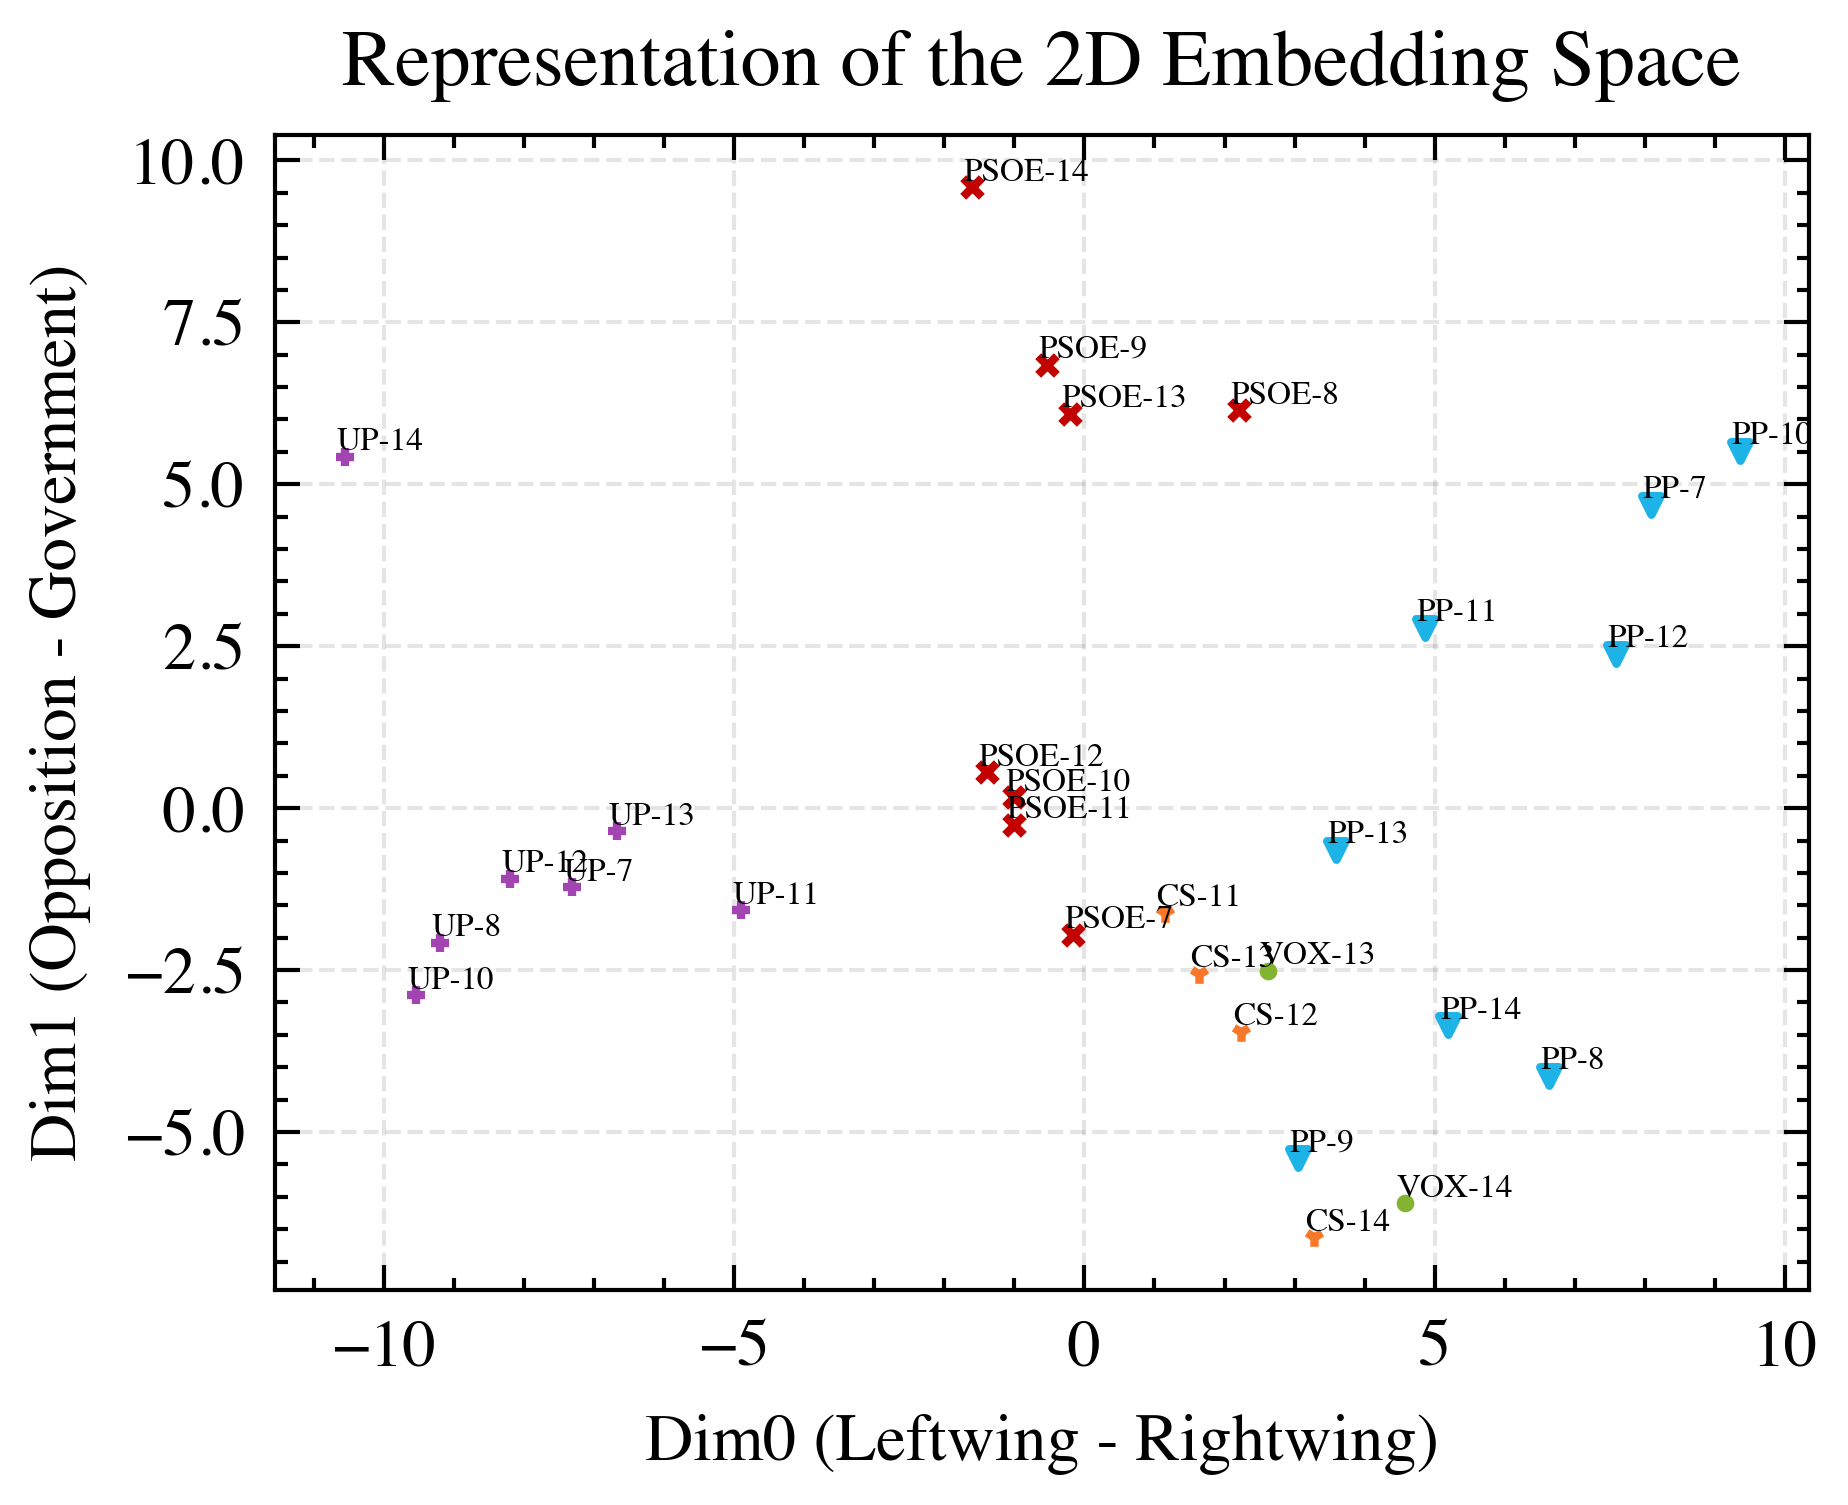

In [32]:
# Embedding space plotting and dimensionality reduction.

def get_color(reduced):
    spk = reduced.speaker.tolist()
    col = []
    marker = []
    for i in range(len(spk)):
        if 'VOX' in spk[i]:
            # #82b431
            # rgba(130,180,49,255)
            col.append('#82b431')
            marker.append('.')
        elif 'PSOE' in spk[i]:
            # #c10200
            # rgba(193,2,0,255)
            col.append('#c10200')
            marker.append('x')
        elif 'IU' in spk[i]:
            # #c10200
            # rgba(193,2,0,255)
            col.append('#8b0000')
            marker.append('2')
        elif 'CS' in spk[i]:
            # #f87729
            # rgba(248,119,41,255)
            col.append('#f87729')
            marker.append('1')
        elif 'PP' in spk[i]:
            # #1eb3e6
            # rgba(30,179,230,255)
            col.append('#1eb3e6')
            marker.append('v')
        elif 'UP' in spk[i]:
            # #a245b2
            # rgba(162,69,178,255)
            col.append('#a245b2')
            marker.append('+')
        elif 'ERC' in spk[i]:
            # #f99f00
            # rgba(249,159,0,255)
            col.append('#f99f00')
            marker.append('2')
        elif 'PNV' in spk[i]:
            # #008146
            # rgba(0,129,70,255)
            col.append('#008146')
            marker.append('2')
        elif 'EHB' in spk[i]:
            # #bbce00
            # rgba(187,206,0,255)
            col.append('#bbce00')
            marker.append('2')
        else:
            col.append('#000000')
            marker.append('2')

    reduced['col'] = col
    reduced['marker'] = marker
    return reduced


def plot(reduced):
    # Select only parties:
    rp = reduced.loc[reduced['speaker'].str.contains('-')]

    #plt.figure(figsize=(12, 12))
    #plt.scatter(rp.dim0, rp.dim1, c=rp.col, marker=rp.marker)
    for xp, yp, c, m in zip(rp.dim0*0.31*-1, rp.dim1*0.31, rp.col, rp.marker):
        plt.scatter(xp, yp, marker=m, c=c, s=5)

    # Change marker type depending on political party. Change marker size.

    for label, x, y in zip(rp.speaker, rp.dim0*0.31*-1, rp.dim1*0.31):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 0),
            textcoords='offset points', ha='left', va='bottom',
            fontsize=4)

    plt.title('Representation of the 2D Embedding Space')
    plt.xlabel('Dim0 (Leftwing - Rightwing)')
    plt.ylabel('Dim1 (Opposition - Government)')

    plt.grid(alpha=.1)


Z, dr = reduce_dimension(model=model, method='pca')
reduced = get_color(Z)
plot(reduced)


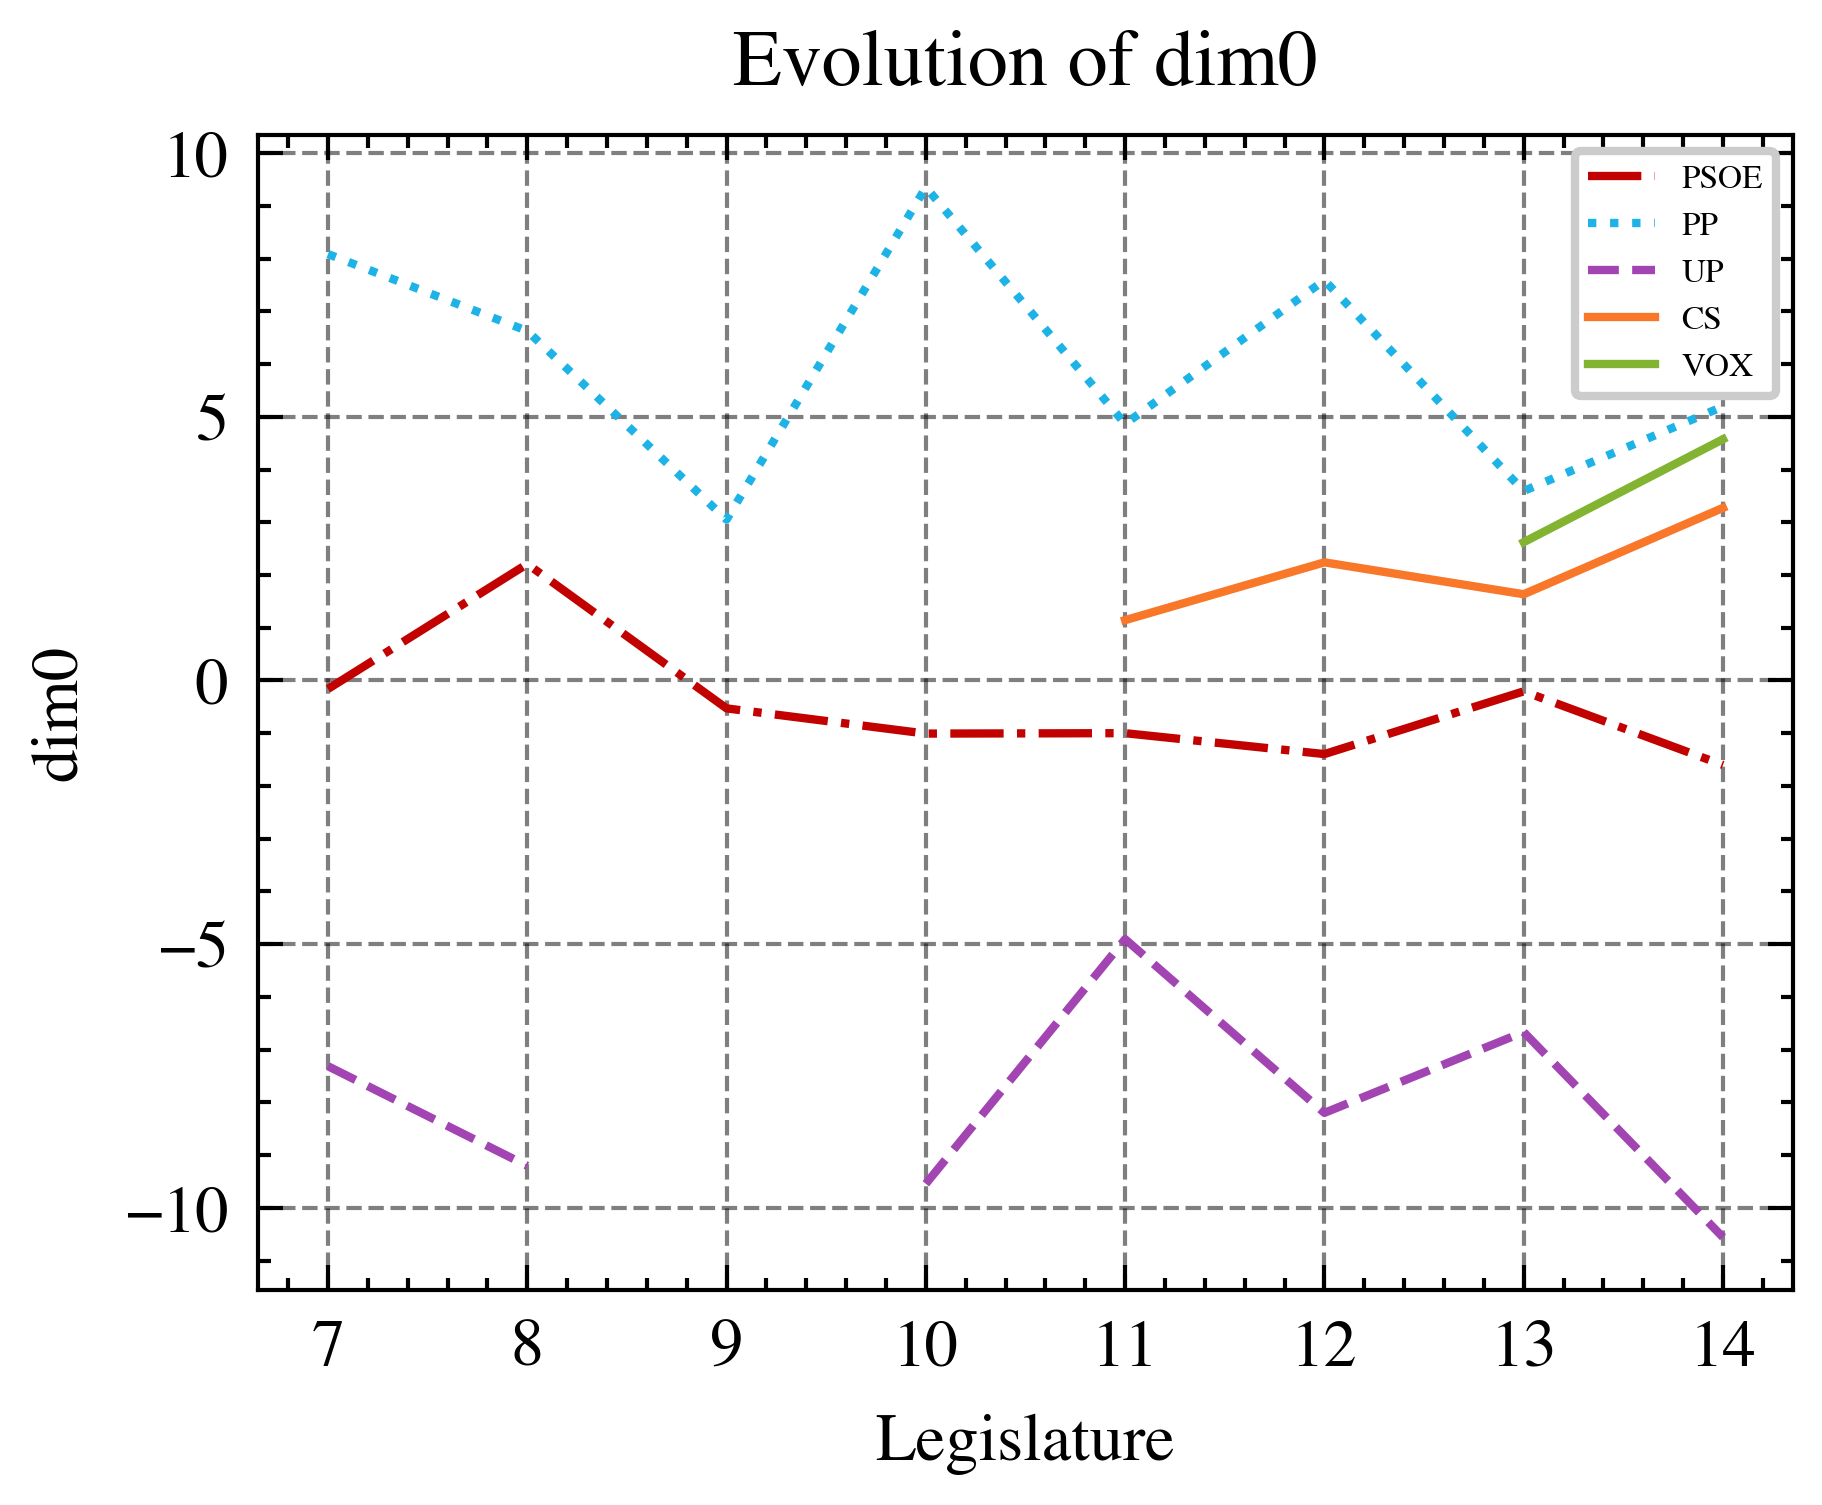

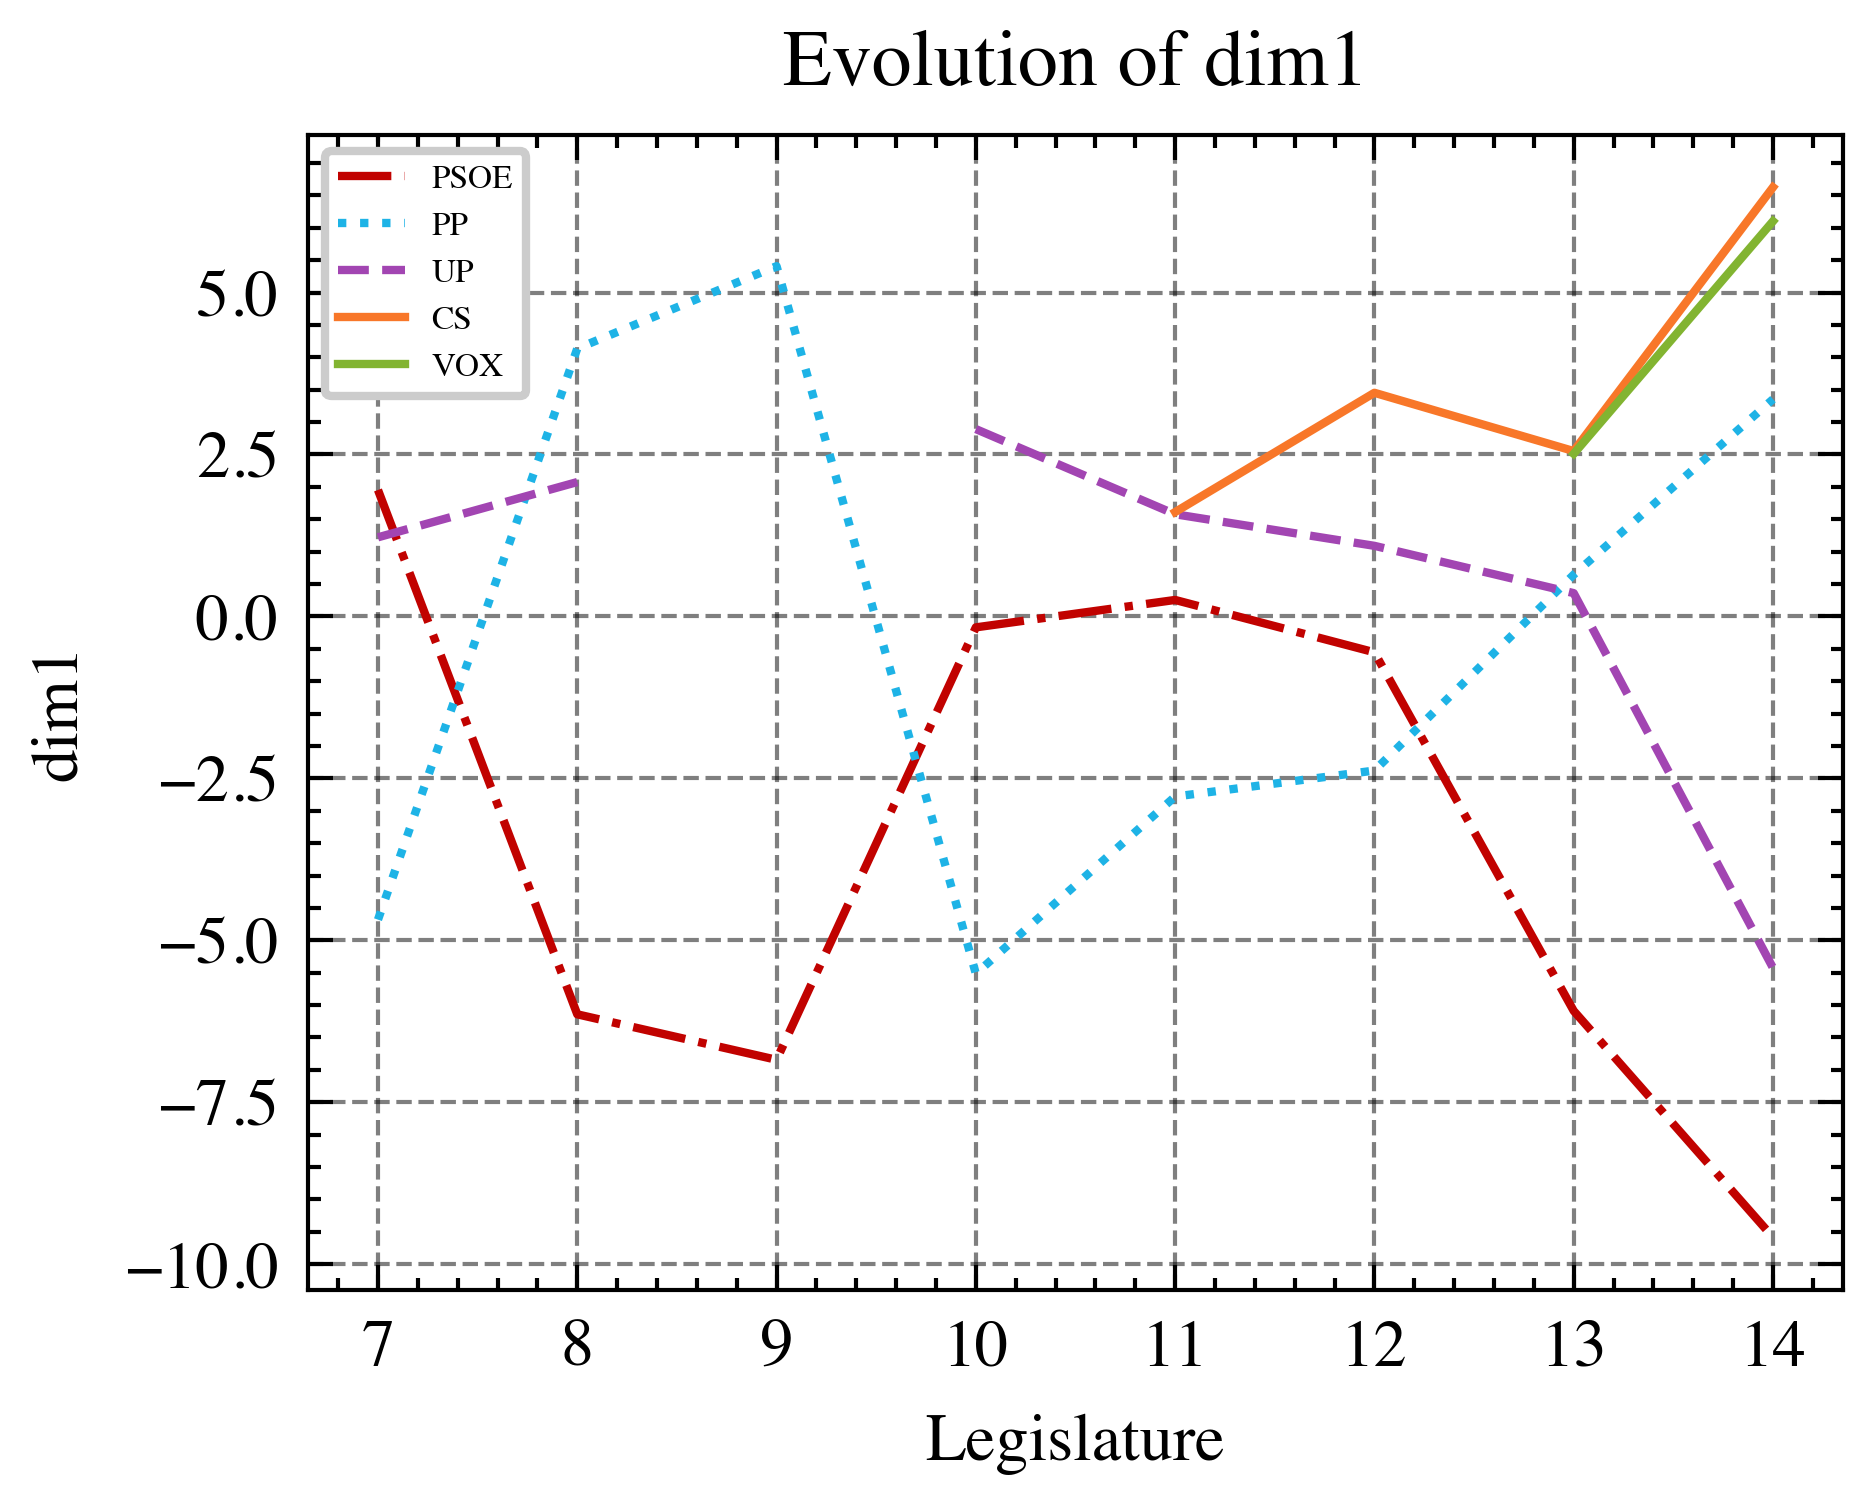

In [291]:
# Dimesions plot.
def plot_ts(dim, reduced):

    # Select only political groups:
    rp = reduced.loc[reduced['speaker'].str.contains('-')]

    # Legislature.
    rp['leg'] = [i[1] for i in rp['speaker'].str.split('-')]
    rp['party'] = [i[0] for i in rp['speaker'].str.split('-')]

    # Pivot.
    rp['leg'] = rp['leg'].astype(int)
    rp = rp.pivot(index='leg', columns='party', values=['dim0', 'dim1'])

    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Plot each time series on the same axis
    ax.plot(rp[f'{dim}', 'PSOE']*-0.31, label='PSOE',
            color='#c10200', linestyle='-.')
    ax.plot(rp[f'{dim}', 'PP']*-0.31, label='PP',
            color='#1eb3e6', linestyle=':')
    ax.plot(rp[f'{dim}', 'UP']*-0.31, label='UP',
            color='#a245b2', linestyle='--')
    ax.plot(rp[f'{dim}', 'CS']*-0.31, label='CS',
            color='#f87729', linestyle='-')
    ax.plot(rp[f'{dim}', 'VOX']*-0.31, label='VOX',
            color='#82b431', linestyle='-')

    # Add a legend and set the title
    ax.set_title(f'Evolution of {dim}')
    ax.legend(fontsize=4)
    plt.xlabel('Legislature')
    plt.ylabel(f'{dim}')
    plt.xticks(ticks=[7, 8, 9, 10, 11, 12, 13, 14])

    # Show the plot
    plt.show()


plot_ts('dim0', reduced)
plot_ts('dim1', reduced)


In [33]:
dr.explained_variance_ratio_

array([0.36620036, 0.21382731])

In [ ]:
model.dv.most_similar(model.dv['movimiento_feminista'], topn=50)


In [48]:
# Fix the pandas list as string.
test['text'] = test['text'].apply(st)

In [49]:
test

,party,legislature,text
51977,PSOE-14,L14,"[argenta, argenta_aldea_director_establecimien..."
20170,PP-9,L9,"[secretaria, año, doy_bienvenida, tratamos, ve..."
26535,UP-10,L10,"[tres, cosas, tres, provocarían, minoración, s..."
4038,PSOE-7,L7,"[quiero, empezar_saludando, gozalo, dándole_bi..."
29298,PP-10,L10,"[primer_lugar_quiero_agradecer, trabajo_realiz..."
...,...,...,...
19389,PSOE-9,L9,"[informe, impacto_medioambiental, procedimient..."
6320,PP-7,L7,"[hacienda, secretaría, gastos, bajo_dirección,..."
42916,PP-14,L14,"[independientemente, carácter, ideología, form..."
52758,PSOE-14,L14,"[miraba, lobo, ayunas, buscando, pelea, atraíd..."


In [113]:
# Infer 1 vector.
#test_vector = model.infer_vector(test.loc[4038].text, alpha=None, min_alpha=None, epochs=None)

# Find most-similar tags.
#model.dv.most_similar(test_vector, topn=10)

In [244]:
t = test['party'].str.split('-')
for i in t.index:
    t[i] = t[i][0]

zeroR = 2098/5881

#plt.bar(x = ['CS', 'PP', 'PSOE', 'UP', 'VOX'], height=[452, 2098, 2018, 947, 366])

In [245]:
zeroR

0.3567420506716545

In [259]:
# Running the classification testing.
from collections import OrderedDict
cor = []
rg = []

#pl = test.party.unique().tolist()
pl = ['PP', 'PSOE', 'UP', 'VOX', 'CS']

iter = [1, 2, 3, 4]

predicted = []
actual = []

for i in iter:
    correct = 0
    random_guessing = 0

    for ix in test.index:
        vector = model.infer_vector(test.loc[ix].text, alpha=None, min_alpha=None, epochs=None)
        lst = model.dv.most_similar(vector, topn=20)
        
        random.shuffle(pl)

        clean = []
        for item in lst:
            if 'L' not in item[0]: clean.append(item[0])

        party = test.loc[ix].party.split('-')[0]
        clean = [p.split('-')[0] for p in clean]
        clean = list(OrderedDict.fromkeys(clean))

        if party in pl[0:i]: random_guessing += 1

        if party in clean[0:i]: correct += 1

        predicted.append(clean[0])
        actual.append(party)
    
    cor.append(correct)
    rg.append(random_guessing)

print(f'correct: {cor}')
print(f'random : {rg}')

print(actual)
print(predicted)

correct: [2580, 4472, 5227, 5721]
random : [1178, 2314, 3621, 4740]
['PSOE', 'PP', 'UP', 'PSOE', 'PP', 'PP', 'UP', 'PSOE', 'PP', 'PP', 'PP', 'VOX', 'CS', 'PSOE', 'UP', 'CS', 'PSOE', 'PSOE', 'PSOE', 'PSOE', 'PP', 'PSOE', 'UP', 'PP', 'PSOE', 'PP', 'PP', 'PP', 'PP', 'UP', 'PP', 'PP', 'UP', 'PP', 'VOX', 'PP', 'PSOE', 'PSOE', 'PSOE', 'PP', 'PSOE', 'PP', 'CS', 'PP', 'PP', 'PP', 'PP', 'PSOE', 'PSOE', 'PP', 'PP', 'UP', 'PP', 'PP', 'PP', 'UP', 'CS', 'PSOE', 'PSOE', 'UP', 'CS', 'PP', 'PSOE', 'PP', 'PSOE', 'PSOE', 'PP', 'VOX', 'PSOE', 'CS', 'UP', 'PSOE', 'UP', 'UP', 'PP', 'PP', 'PP', 'PP', 'UP', 'CS', 'PP', 'PP', 'PP', 'PSOE', 'CS', 'UP', 'PP', 'PP', 'UP', 'CS', 'UP', 'PP', 'CS', 'PSOE', 'PSOE', 'PSOE', 'PP', 'PP', 'PSOE', 'CS', 'PP', 'PP', 'PSOE', 'PSOE', 'UP', 'PSOE', 'PP', 'PP', 'UP', 'PP', 'PSOE', 'PP', 'UP', 'PSOE', 'CS', 'UP', 'PSOE', 'PP', 'PSOE', 'PSOE', 'UP', 'PSOE', 'PP', 'PP', 'PSOE', 'PP', 'CS', 'VOX', 'PP', 'PSOE', 'CS', 'PP', 'VOX', 'UP', 'VOX', 'CS', 'PP', 'PSOE', 'PSOE', 'PP', 'PP

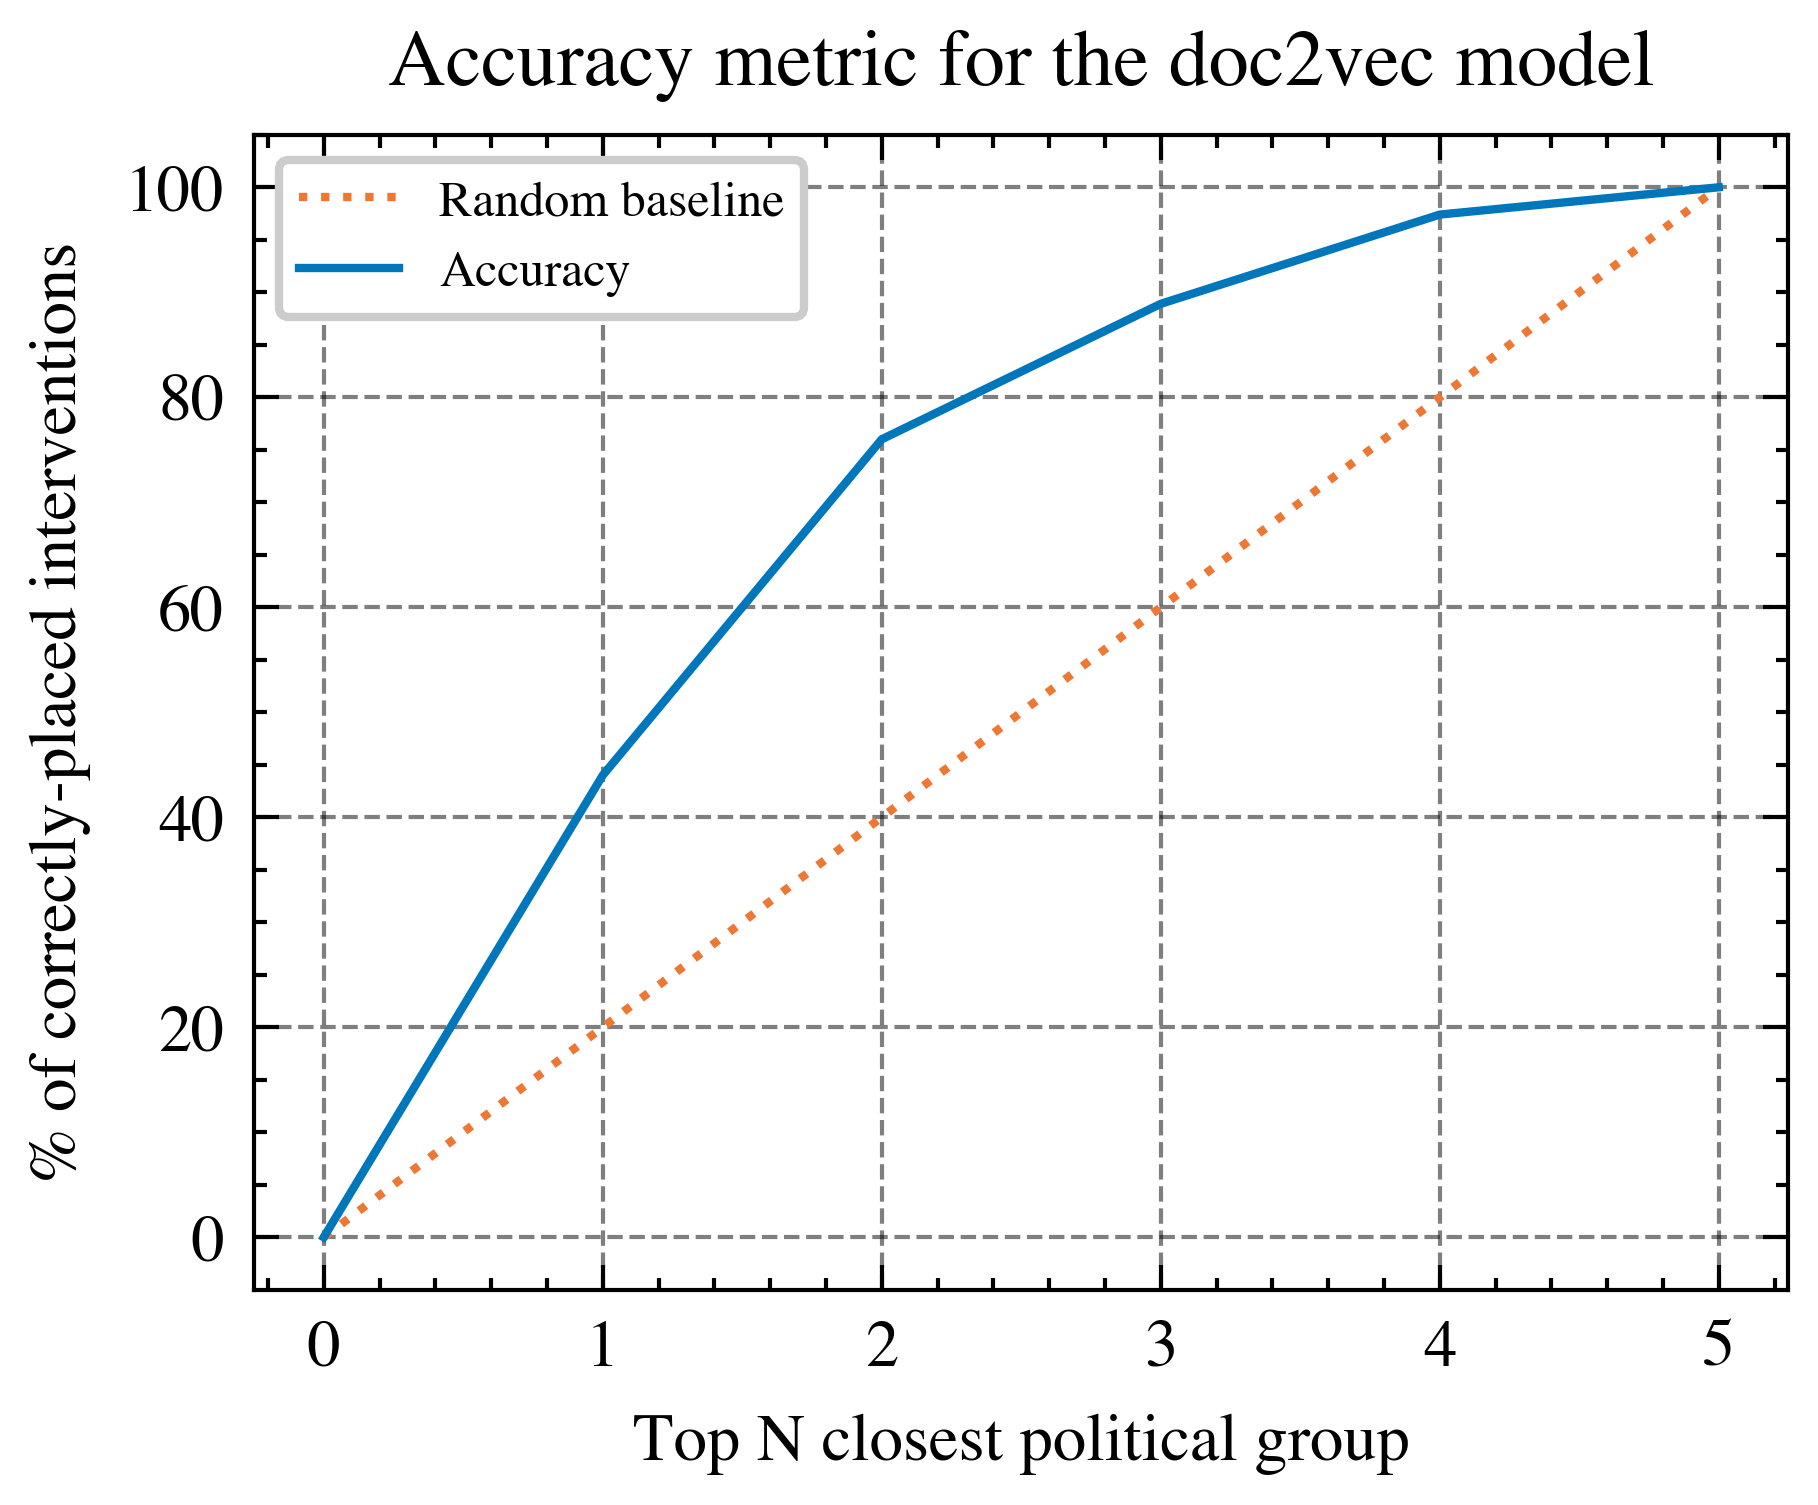

In [288]:
# Plot accuracy evaluation.
eval = pd.DataFrame(index=[0, 1, 2, 3, 4, 5], data = {'Random (P)'  :[0, 20, 40, 60, 80, 100],
                                                           'P'           :[0, 44, 76, 88.9, 97.4, 100]})

fig, ax = plt.subplots()

ax.plot(eval['Random (P)'], label='Random baseline', ls='dotted')
ax.plot(eval['P'], label='Accuracy')
ax.set(yticks = [0, 20, 40, 60, 80, 100], xticks = [0, 1, 2, 3, 4, 5])
ax.set(title='Accuracy metric for the doc2vec model',
       ylabel=f'% of correctly-placed interventions',
       xlabel='Top N closest political group')
ax.legend(fontsize=6)

#### CHES

It does not seem to me that this is the best way to evaluate this model. I believe the evaluation should be based on how good the model performs when it comes to actually assessing the L-R index, for example. For that, I will be comparing the results of the model with the Chapel Hill Expert Survey (CHES) results for the available time. The item used from CHES is LRGEN: the general left-right index, where 0 is extreme left and 10 extreme right.

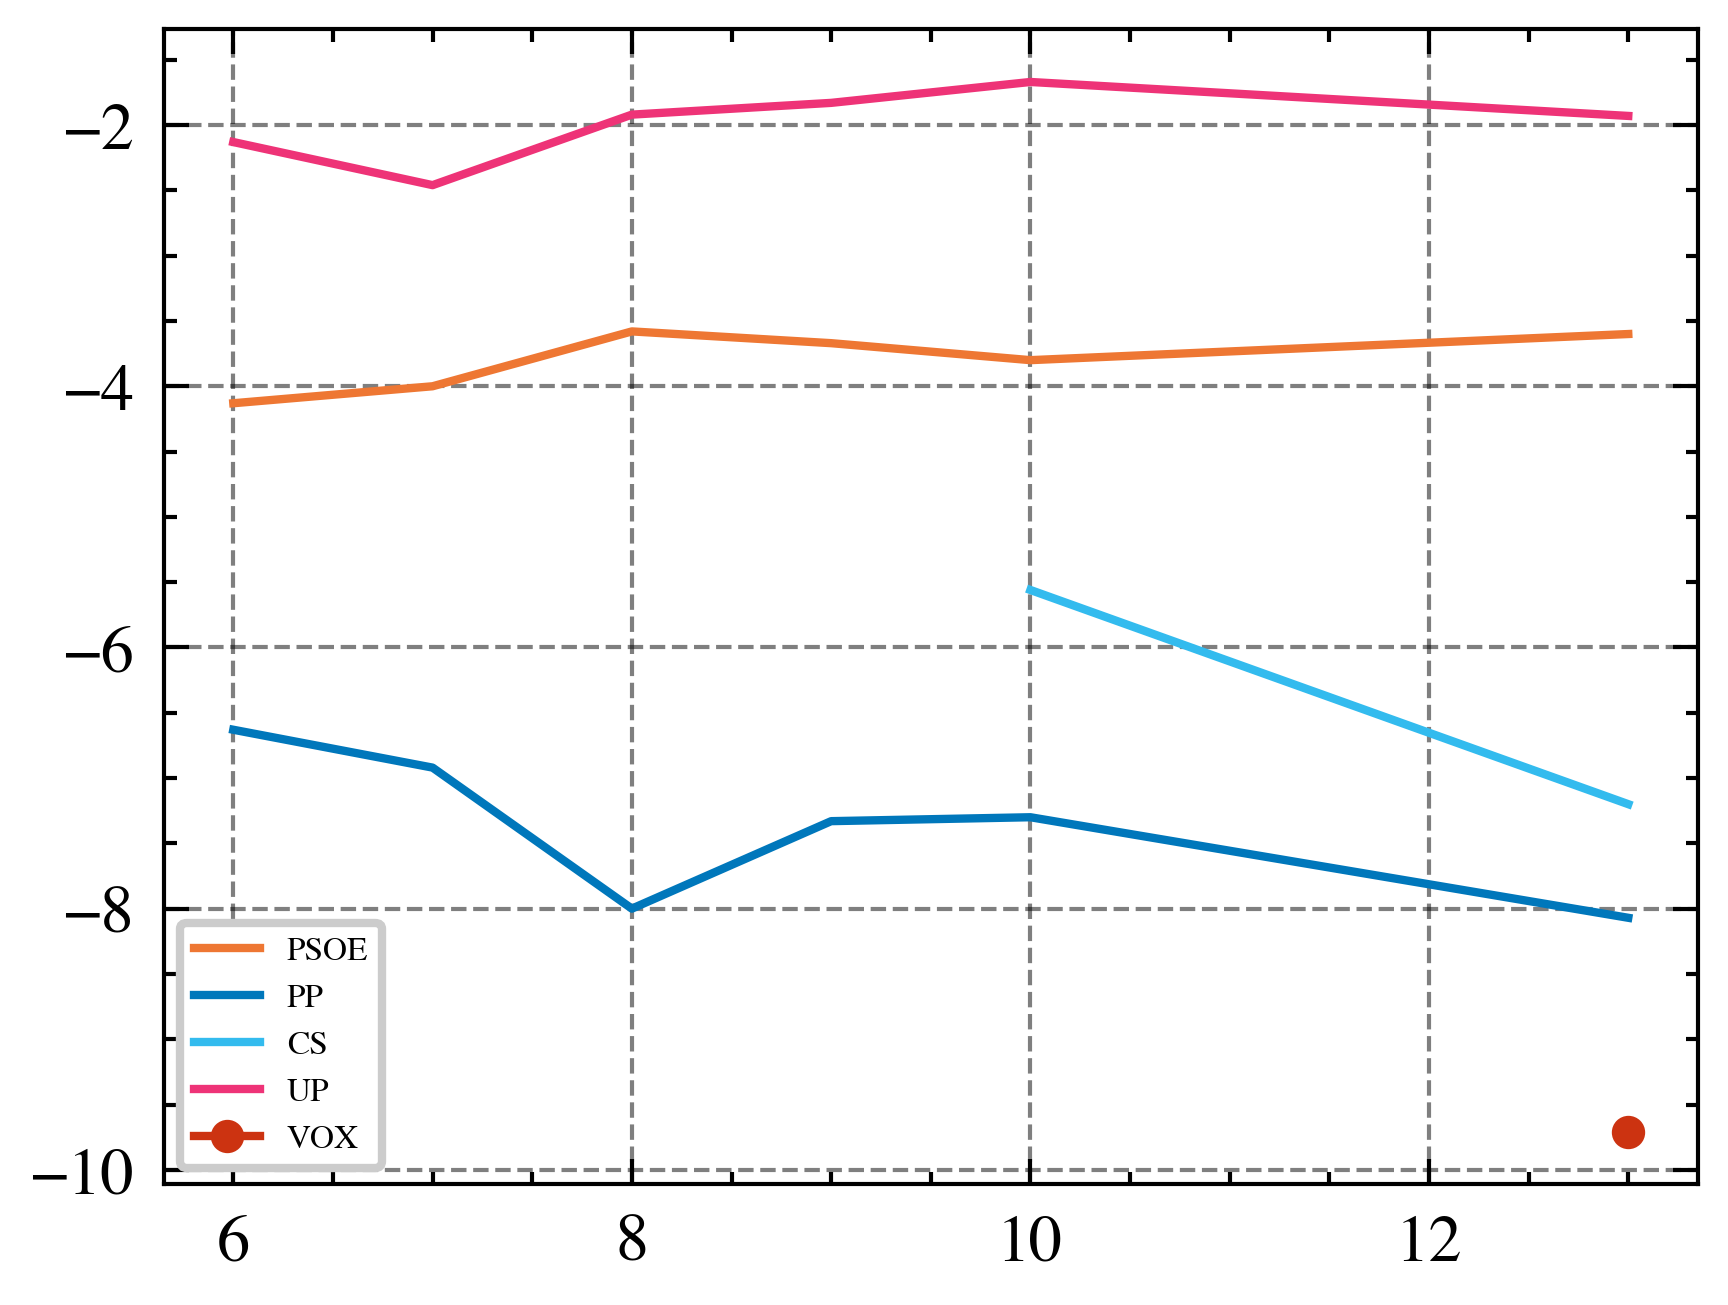

In [88]:
index = [6, 7, 8, 9, 10, 13]
PSOE = [4.13, 4, 3.58, 3.67, 3.8, 3.6]
PP = [6.63, 6.92, 8, 7.33, 7.3, 8.07]
CS = [np.nan, np.nan, np.nan, np.nan, 5.56, 7.2]
UP = [2.13, 2.46, 1.92, 1.83, 1.67, 1.93]
VOX = [np.nan, np.nan, np.nan, np.nan, np.nan, 9.71]

CHES = pd.DataFrame(index=index, data={
                    'PSOE': PSOE, 'PP': PP, 'CS': CS, 'UP': UP, 'VOX': VOX})

fig, ax = plt.subplots()
ax.plot(-CHES.PSOE, label = 'PSOE')
ax.plot(-CHES.PP, label='PP')
ax.plot(-CHES.CS, label='CS')
ax.plot(-CHES.UP, label='UP')
ax.plot(-CHES.VOX, label='VOX', marker='.', lw=1)
ax.legend(fontsize='4')
